# 프로젝트 개요

'나만의 딥러닝 기반 추천 시스템 구축하기'는 AutoInt+ 모델을 직접 구현해보고 최종적으로 스트림릿(Streamlit)을 활용해 시각화하는 과정을 담고 있습니다.

본 소스에서는 구현된 AutoInt+ 모델을 활용하여 모델을 학습하고 파라미터 튜닝을 통한 최적 모델 탐색과정을 다룹니다.







## 진행 순서

Step 1. 데이터 불러오기 및 세팅
___
- 이전 학습에서 전처리던 `MovieLens1M` 데이터를 불러옵니다. 
- 모델 input으로 넣어 학습하기 위한 세팅을 수행합니다. 

Step 2. 모델 학습
___
- 활용할 모델인 `AutoIntMLPModel`은 특징 상호작용을 위한 **AutoInt** 부분과 피드포워드 신경망을 위한 **MLP** 부분을 결합한 추천 시스템 모델입니다.
- 원활한 학습을 위한 옵티마이저, 콜백 등을 세팅하고, 모델 학습을 수행합니다. 
- 학습 후 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 확인하기 위한 평가지표로 `NDCG`와 `Hitrate`를 활용하였습니다. 

Step 3. 파라미터 튜닝
___
- 임베딩 크기, 드롭아웃, 학습률에 대해 파라미터 튜닝을 수행합니다. 
- 튜닝된 모델로 평가를 수행합니다.

Step 4. 저장
___
- 학습된 모델을 저장합니다.

# 데이터 불러오기 및 세팅
___
- 실습에서 사용할 데이터는 `MovieLens1M` 데이터셋로, 전처리하였던 데이터를 불러옵니다. 

- 모델 input으로 넣어 학습하기 위한 세팅을 수행합니다. 

    1. 데이터 불러오기
    2. 레이블 인코더(label encoder)를 통해 0부터 피처(feature)의 고유 개수까지 매핑

        - 예) 성별: 남(M), 여(F)를 0, 1로 변환
        - 예) 장르: 코메디, 드라마, 액션을 0, 1, 2로 변환

    3. 학습(train) 데이터와 테스트(test) 데이터로 분리

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import os
import math
import joblib

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras_tuner import Hyperband

from autointp import AutoIntMLPModel, predict_model

from typing import Optional


1. 데이터 불러오기

In [2]:
project_path = os.path.abspath(os.getcwd())
data_dir_nm = 'data'; movielens_dir_nm = 'ml-1m'; model_dir_nm = 'model'

data_path = f"{project_path}/{data_dir_nm}"
model_path = f"{project_path}/{model_dir_nm}"

In [3]:
movielens_rcmm = pd.read_csv(f'{data_path}/{movielens_dir_nm}/movielens_rcmm_v2.csv', dtype=str)

print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2000,12,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2000,12,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2000,12,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2000,12,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


2. 레이블 인코더(label encoder)를 통해 0부터 피처(feature)의 고유 개수까지 매핑

In [4]:
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킵니다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

3. 학습(train) 데이터와 테스트(test) 데이터로 분리

In [5]:
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int32  
 1   movie_id       800167 non-null  int32  
 2   movie_decade   800167 non-null  int32  
 3   movie_year     800167 non-null  int32  
 4   rating_year    800167 non-null  int32  
 5   rating_month   800167 non-null  int32  
 6   rating_decade  800167 non-null  int32  
 7   genre1         800167 non-null  int32  
 8   genre2         800167 non-null  int32  
 9   genre3         800167 non-null  int32  
 10  gender         800167 non-null  int32  
 11  age            800167 non-null  int32  
 12  occupation     800167 non-null  int32  
 13  zip            800167 non-null  int32  
 14  label          800167 non-null  float32
dtypes: float32(1), int32(14)
memory usage: 51.9 MB


In [7]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다.
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'

field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439], dtype=int64)

# 모델 학습
___
- 활용할 모델인 `AutoIntMLPModel`은 특징 상호작용을 위한 **AutoInt** 부분과 피드포워드 신경망을 위한 **MLP** 부분을 결합한 추천 시스템 모델입니다.

- 여기서, 추천 모델 훈련 진행을 위한 세팅 그리고 모델 학습을 진행합니다.

1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

## 평가지표

In [8]:
# 평가 함수는 아래의 링크에서 가져왔습니다.
# https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

## 모델 테스트 함수

In [9]:
def test_model(model, test_df):
    '''모델 테스트'''
    from collections import defaultdict
    
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

## 모델 구성

AutoIntMLPModel 파라미터 간략 설명

| 파라미터 | 설명 | AutoInt/MLP 파트 |
| :--- | :--- | :--- |
| **`field_dims`** | **특성(Field)별 고유 인덱스의 총 개수 목록**입니다. (예: `[사용자 수, 아이템 수, 성별 수, ... ]`). 임베딩 테이블 크기를 정의하는 데 필수적입니다. | 공통 |
| **`embedding_size`** | 각 특성(Field)을 벡터로 변환할 때 사용할 **임베딩 벡터의 차원** ($E$)입니다. 모델의 표현력을 결정합니다. | 공통 |
| **`att_layer_num`** | **Multi-Head Self-Attention 레이어의 개수**입니다. 상호작용을 몇 단계로 깊게 모델링할지 결정합니다. (기본값: 3) | AutoInt |
| **`att_head_num`** | 각 Self-Attention 레이어 내에서 사용할 **어텐션 헤드의 개수**입니다. 병렬적인 상호작용 패턴 탐색을 가능하게 합니다. (기본값: 2) | AutoInt |
| **`att_res`** | 어텐션 레이어에 **잔차 연결(Residual Connection)**을 사용할지 여부입니다. `True`인 경우 학습 안정성을 높여줍니다. (기본값: True) | AutoInt |
| **`l2_reg_dnn`** | MLP(DNN) 부분의 가중치에 적용할 **L2 정규화 강도**입니다. (기본값: 0) | MLP |
| **`l2_reg_embedding`** | **임베딩 가중치**에 적용할 **L2 정규화 강도**입니다. 오버피팅을 방지합니다. (기본값: 1e-5) | 공통 |
| **`dnn_use_bn`** | MLP 레이어 사이에 **배치 정규화(Batch Normalization)**를 사용할지 여부입니다. (기본값: False) | MLP |
| **`dnn_dropout`** | MLP 레이어 사이에 적용할 **드롭아웃 비율**입니다. 오버피팅 방지용입니다. | MLP |
| **`init_std`** | 가중치 초기화 시 사용할 **표준 편차**입니다. 작은 값일수록 초기 가중치가 0에 가깝습니다. (기본값: 0.0001) | 공통 |

In [10]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=5
learning_rate= 0.0001
dropout= 0.4
batch_size = 2048
embed_dim= 16

In [11]:
# 모델 정의
autoIntMLP_model = AutoIntMLPModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                             , dnn_dropout=dropout, init_std=0.0001)

In [12]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

# 모델 컴파일
autoIntMLP_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['binary_crossentropy']
  )

## 훈련 및 평가

In [13]:
# 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True, # 가장 낮은 val_loss를 기록한 시점의 가중치를 복원
    verbose=1
)

In [ ]:
epochs = 200

history = autoIntMLP_model.fit(
    train_df[u_i_feature + meta_features],
    train_df[label],
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping]
  )

Epoch 1/200


In [ ]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리
user_pred_info = {}

# top 10개
top = 10

# 테스트 값을 가지고 옵니다.
mymodel_user_pred_info = test_model(autoIntMLP_model, test_df)

# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다.
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist

# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13940\1713209293.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|██████████| 6035/6035 [00:00<00:00, 96080.96it/s]


In [ ]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 61501.38it/s]


In [ ]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.65402
 mymodel hitrate :  0.62511


# 파라미터 튜닝

- `Keras Tuner`를 활용하여 파라미터들에 대한 튜닝을 수행하였습니다. 
- 튜닝은 학습과 마찬가지로 `Binary Crossentropy`를 최소화하는 방향으로 수행하되, `AUC` 또한 함께 모니터링 하였습니다.

## 튜닝 모델 구성

In [ ]:
# 1. 튜닝 모델 정의
def build_model(hp):
    # Keras Tuner가 탐색할 하이퍼파라미터 정의
    
    # 임베딩 크기 (16, 32, 64 중 선택)
    embedding_size = hp.Choice('embedding_size', values=[16, 32, 64])
    
    # 드롭아웃 (0.1, 0.3, 0.5 중 선택)
    mlp_dropout = hp.Choice('mlp_dropout', values=[0.1, 0.3, 0.5])
    
    # 학습률 (로그 스케일로 탐색)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')

    # AutoIntMLPModel 인스턴스 생성
    model = AutoIntMLPModel(
        field_dims = field_dims, 
        embedding_size = embedding_size,    # 튜닝된 값 사용
        dnn_dropout = mlp_dropout,          # 튜닝된 값 사용
    )
    
    # 모델 컴파일
    model.compile(
        optimizer= Adam(learning_rate = learning_rate),  # 튜닝된 값 사용
        loss = BinaryCrossentropy(from_logits=False),
        metrics = [tf.keras.metrics.AUC(name='AUC')],  
    )

    return model

# 2. 튜너 인스턴스 생성
tuner = Hyperband(
    build_model,
    objective='val_AUC', # 검증 AUC를 최대화하는 방향으로 최적화
    max_epochs=100,       # 각 시도당 최대 100 에포크
    factor=3,
    directory='my_tuning_dir',
    project_name='autointp_tuning'
)
# 3. 튜닝 실행
tuner.search(train_df[u_i_feature + meta_features],
             train_df[label],
             epochs=50, 
             validation_split=0.1,
             batch_size = 2048
)

Reloading Tuner from my_tuning_dir\autointp_tuning\tuner0.json


In [ ]:
# 전역 변수 설정
TUNER_DIR = 'my_tuning_dir'
PROJECT_NAME = 'autointp_tuning'
FINAL_WEIGHTS_FILE = './model/autointMLP+_model_weights.weights.h5'
LABEL_ENCODERS_FILE = './data/autoIntMLP_label_encoders.pkl'

# 주의: 이 파일에서는 build_model 함수와 field_dims, label_encoders 변수가
# 외부 스코프에 정의되어 있어야 정상 작동합니다.

def load_and_save_best_model(build_model_fn, tuner_dir: str, project_name: str, fallback_trial_id: str = '0003') -> Optional[tf.keras.Model]:
    """
    Keras Tuner 기록에서 최적 모델의 가중치를 추출하고 저장합니다.
    
    Args:
        build_model_fn: Keras Tuner의 HyperModel에서 사용하는 모델 생성 함수.
        tuner_dir: 튜닝 기록 폴더 경로.
        project_name: 튜닝 프로젝트 이름.
        fallback_trial_id: 최적 트라이얼에 파일이 없을 경우 사용할 폴백 Trial ID.
        
    Returns:
        로드된 최적 모델 (tf.keras.Model) 또는 로드 실패 시 None.
    """
    
    # 1. 튜너 객체 재구성
    tuner = Hyperband(
        build_model_fn,
        objective='val_AUC', 
        max_epochs=100,      
        factor=3,
        directory=tuner_dir,
        project_name=project_name,
        # 재로드 시 compile 인자가 필요할 경우 추가
    )
    
    best_model = None
    
    try:
        # 2. 최적 HP 추출 및 모델 빌드
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_trial_id = tuner.oracle.get_best_trials(num_trials=1)[0].trial_id
        
        # 최적 하이퍼파라미터로 모델을 수동으로 빌드
        best_model = tuner.hypermodel.build(best_hp)
        
        # 3. 모델 빌드 (필수)
        # field_dims 변수가 전역 또는 로컬 스코프에 정의되어 있어야 함
        if 'field_dims' in globals() or 'field_dims' in locals():
            best_model.build(input_shape=(None, len(field_dims)))
        else:
            print("⚠️ 경고: 'field_dims' 변수가 없어 모델의 input_shape를 명시적으로 설정하지 못했습니다.")
            # 가중치 로드 시 암묵적 빌드를 기대
            
    except Exception as e:
        print(f"🚨 최적 트라이얼 추출 및 모델 빌드 실패: {e}")
        return None

    # 4. 가중치 로드 및 폴백 로직
    CHECKPOINT_FILE = 'checkpoint.weights.h5'
    best_trial_id_used = best_trial_id
    
    # 최적 트라이얼 경로
    CHECKPOINT_DIR = os.path.join(tuner.directory, tuner.project_name, f'trial_{best_trial_id}')
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILE)
    
    # 가중치 파일 존재 확인 및 폴백
    if not os.path.exists(CHECKPOINT_PATH):
        print(f"⚠️ 경고: Trial {best_trial_id} 경로에 파일이 없습니다. Trial {fallback_trial_id}로 폴백합니다.")
        best_trial_id_used = fallback_trial_id
        CHECKPOINT_DIR = os.path.join(tuner.directory, tuner.project_name, f'trial_{best_trial_id_used}')
        CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILE)

    try:
        # 가중치 파일 로드 시도
        print(f"Reloading Tuner from {CHECKPOINT_PATH}")
        best_model.load_weights(CHECKPOINT_PATH)
        
    except Exception as e:
        print(f"🚨 가중치 로드 최종 실패 (Trial ID: {best_trial_id_used}): {e}")
        return None
        
    # 5. 최종 가중치 및 인코더 저장
    try:
        # Keras 3 형식(.weights.h5)으로 저장
        best_model.save_weights(FINAL_WEIGHTS_FILE)
        print(f"✅ 최적 모델 가중치 업데이트 완료: {FINAL_WEIGHTS_FILE}")
        
        # 레이블 인코더 저장
        if 'label_encoders' in globals() or 'label_encoders' in locals():
            joblib.dump(label_encoders, LABEL_ENCODERS_FILE)
            print("✅ label_encoders 객체가 저장되었습니다.")
        else:
            print("⚠️ 'label_encoders' 변수가 정의되지 않아 인코더 저장을 건너뜜니다.")
            
    except Exception as e:
        print(f"🚨 최종 파일 저장 실패: {e}")
        
    # 6. 결과 요약 출력
    print("\n[최적 파라미터 요약]")
    print(f"로딩에 사용된 Trial ID: {best_trial_id_used} (HP는 원래 최적 트라이얼({best_trial_id})의 것입니다.)")
    print(f"Embedding Size: {best_hp.get('embedding_size')}")
    print(f"MLP Dropout: {best_hp.get('mlp_dropout')}")
    print(f"Learning Rate: {best_hp.get('learning_rate')}")
    
    return best_model

In [ ]:
# 튜닝기록으로부터 모델 불러오기
final_model = load_and_save_best_model(
    build_model, 
    TUNER_DIR, 
    PROJECT_NAME, 
    fallback_trial_id='0003'
)

if final_model:
    print("\n🎉 모델 로드 및 저장 과정이 성공적으로 완료되었습니다.")

Reloading Tuner from my_tuning_dir\autointp_tuning\tuner0.json
Reloading Tuner from my_tuning_dir\autointp_tuning\trial_0003\checkpoint.weights.h5
✅ 최적 모델 가중치 업데이트 완료: ./model/autointMLP+_model_weights.weights.h5
✅ label_encoders 객체가 저장되었습니다.

[최적 파라미터 요약]
로딩에 사용된 Trial ID: 0003 (HP는 원래 최적 트라이얼(0003)의 것입니다.)
Embedding Size: 64
MLP Dropout: 0.1
Learning Rate: 0.0002795068690232021

🎉 모델 로드 및 저장 과정이 성공적으로 완료되었습니다.


c:\Users\Hopedom\.conda\envs\DS5-Rec\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'auto_int_mlp_model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


## 결과 요약

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import pandas as pd

# 1. 튜너 객체를 재구성합니다.
# build_model 함수가 정의되어 있다고 가정합니다.
tuner = Hyperband(
    build_model,
    objective='val_AUC', 
    max_epochs=100,      
    factor=3,
    directory='my_tuning_dir',
    project_name='autointp_tuning'
)

# 2. 오라클 객체를 통해 모든 완료된 트라이얼을 가져옵니다.
# 최대 100개 트라이얼을 시도한다고 가정하고 추출합니다.
all_trials = tuner.oracle.get_best_trials(100)
    
data = []
for trial in all_trials:
    
    score = None
    
    # 💡 이전 오류 해결: 메트릭 객체에 직접 접근하여 점수를 안전하게 추출 💡
    try:
        # 1. 'val_AUC' 메트릭 객체를 안전하게 가져옵니다.
        metric_obj = trial.metrics.metrics.get('val_AUC')
        
        if metric_obj is not None:
            # 2. 메트릭 객체 자체의 get_last_value()를 호출합니다.
            score = metric_obj.get_last_value()
            
    except Exception:
        score = None
    
    # 점수가 있는 트라이얼만 DataFrame에 포함
    if score is None:
        continue
    
    # 3. 데이터 딕셔너리 구성
    trial_data = {
        'Trial ID': f"Trial {trial.trial_id}",
        'val_AUC Score': score,
        'Embedding Size': trial.hyperparameters.get('embedding_size'),
        'MLP Dropout': trial.hyperparameters.get('mlp_dropout'),
        'Learning Rate': trial.hyperparameters.get('learning_rate'),
    }
    data.append(trial_data)

# 4. DataFrame 생성 및 정리
df_reusable = pd.DataFrame(data)

# Score를 기준으로 정렬하고 상위 10개만 선택
df_reusable = df_reusable.sort_values(by='val_AUC Score', ascending=False).reset_index(drop=True)
df_reusable[:30]

Reloading Tuner from my_tuning_dir\autointp_tuning\tuner0.json


,Trial ID,val_AUC Score,Embedding Size,MLP Dropout,Learning Rate
0,Trial 0003,0.770468,64,0.1,0.000280
1,Trial 0010,0.769023,16,0.1,0.000170
2,Trial 0022,0.768350,16,0.5,0.000837
3,Trial 0034,0.767920,64,0.1,0.000424
4,Trial 0029,0.767377,64,0.3,0.000238
5,Trial 0006,0.767255,32,0.3,0.000504
6,Trial 0033,0.767167,64,0.3,0.000412
7,Trial 0005,0.766827,32,0.3,0.000646
8,Trial 0012,0.766635,16,0.5,0.000126
9,Trial 0031,0.765955,32,0.1,0.000791


In [ ]:
best_hp_object = tuner.get_best_hyperparameters(1)[0]
best_hp_values = best_hp_object.values

print("[최적 하이퍼파라미터 (값)]")
print(best_hp_values)
print("-" * 50)

print("[개별 파라미터 추출]")
print(f"Embedding Size: {best_hp_values.get('embedding_size')}")
print(f"MLP Dropout: {best_hp_values.get('mlp_dropout')}")
print(f"Learning Rate: {best_hp_values.get('learning_rate')}")

[최적 하이퍼파라미터 (값)]
{'embedding_size': 64, 'mlp_dropout': 0.1, 'learning_rate': 0.0002795068690232021, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}
--------------------------------------------------
[개별 파라미터 추출]
Embedding Size: 64
MLP Dropout: 0.1
Learning Rate: 0.0002795068690232021


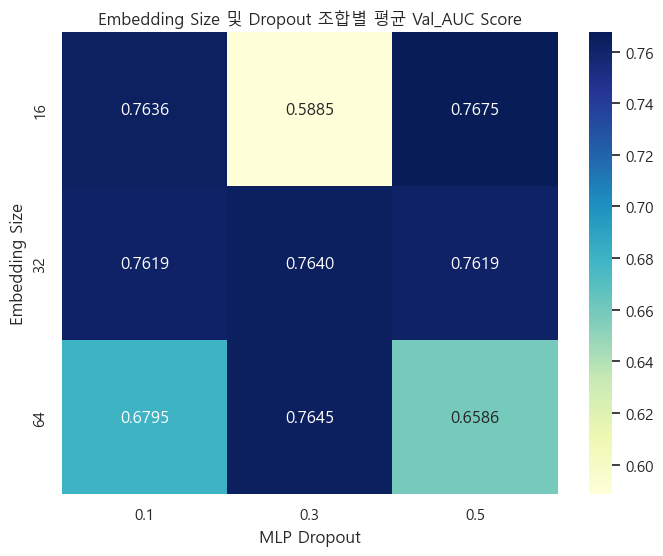

In [ ]:
# 1. 두 파라미터의 평균 점수를 구하는 피벗 테이블 생성
pivot_table = df_reusable.pivot_table(
    values='val_AUC Score', 
    index='Embedding Size', 
    columns='MLP Dropout', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Embedding Size 및 Dropout 조합별 평균 Val_AUC Score')
plt.show()

In [ ]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리
user_pred_info = {}

# top 10개
top = 10

# 테스트 값을 가지고 옵니다.
mymodel_user_pred_info = test_model(best_model, test_df)

# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다.
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist

# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24264\1713209293.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 6035/6035 [00:00<00:00, 96527.96it/s]


In [ ]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

100%|██████████| 5994/5994 [00:00<00:00, 61446.82it/s]

 mymodel ndcg :  0.55787
 mymodel hitrate :  0.572


# 저장
- 튜닝된 모델의 가중치와 객체를 저장합니다.
- 저장된 가중치와 객체를 활용하여 streamlit에서 시각화를 수행합니다.

In [ ]:
# 모델의 가중치(weight) 저장
#autoInt_model.save_weights('./model/autoIntMLP+_model_weights.h5')

In [ ]:
# 모델 객체를 pickled binary file 형태로 저장
#joblib.dump(label_encoders, './data/autoIntMLP_label_encoders.pkl')